In [1]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special
import os.path

%autosave 60

Autosaving every 60 seconds


In [2]:
%%time
n_seq = 10000
Sequences = generate_Sequences(n_seq)

print_raw_file(Sequences, "../Text_files/file2.txt")
generate_newick_format("../Text_files/file2.txt")


[[   0    0]
 [   0    1]
 [   1    2]
 ...
 [3289 9997]
 [9659 9998]
 [7022 9999]]
CPU times: user 15.8 s, sys: 195 ms, total: 16 s
Wall time: 16.1 s


In [3]:
Sequences[8000].master_sequence, Sequences[8000].sequence, Sequences[8000].hamming_distance, Sequences[8000].energy_parent, Sequences[8000].energy, Sequences[8000].delta_energy

('fflqsoaja', 'nheeqiacs', 8, 6.68, 7.14, 0.45999999999999996)

In [14]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 1
R=6
beta = 1
gamma = 1
T = 10000
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                              nu = nu, R = R, beta = beta, master_Sequence_energy = 5)
Model.Gillespie()


CPU times: user 41.2 s, sys: 23.9 s, total: 1min 5s
Wall time: 1min 5s


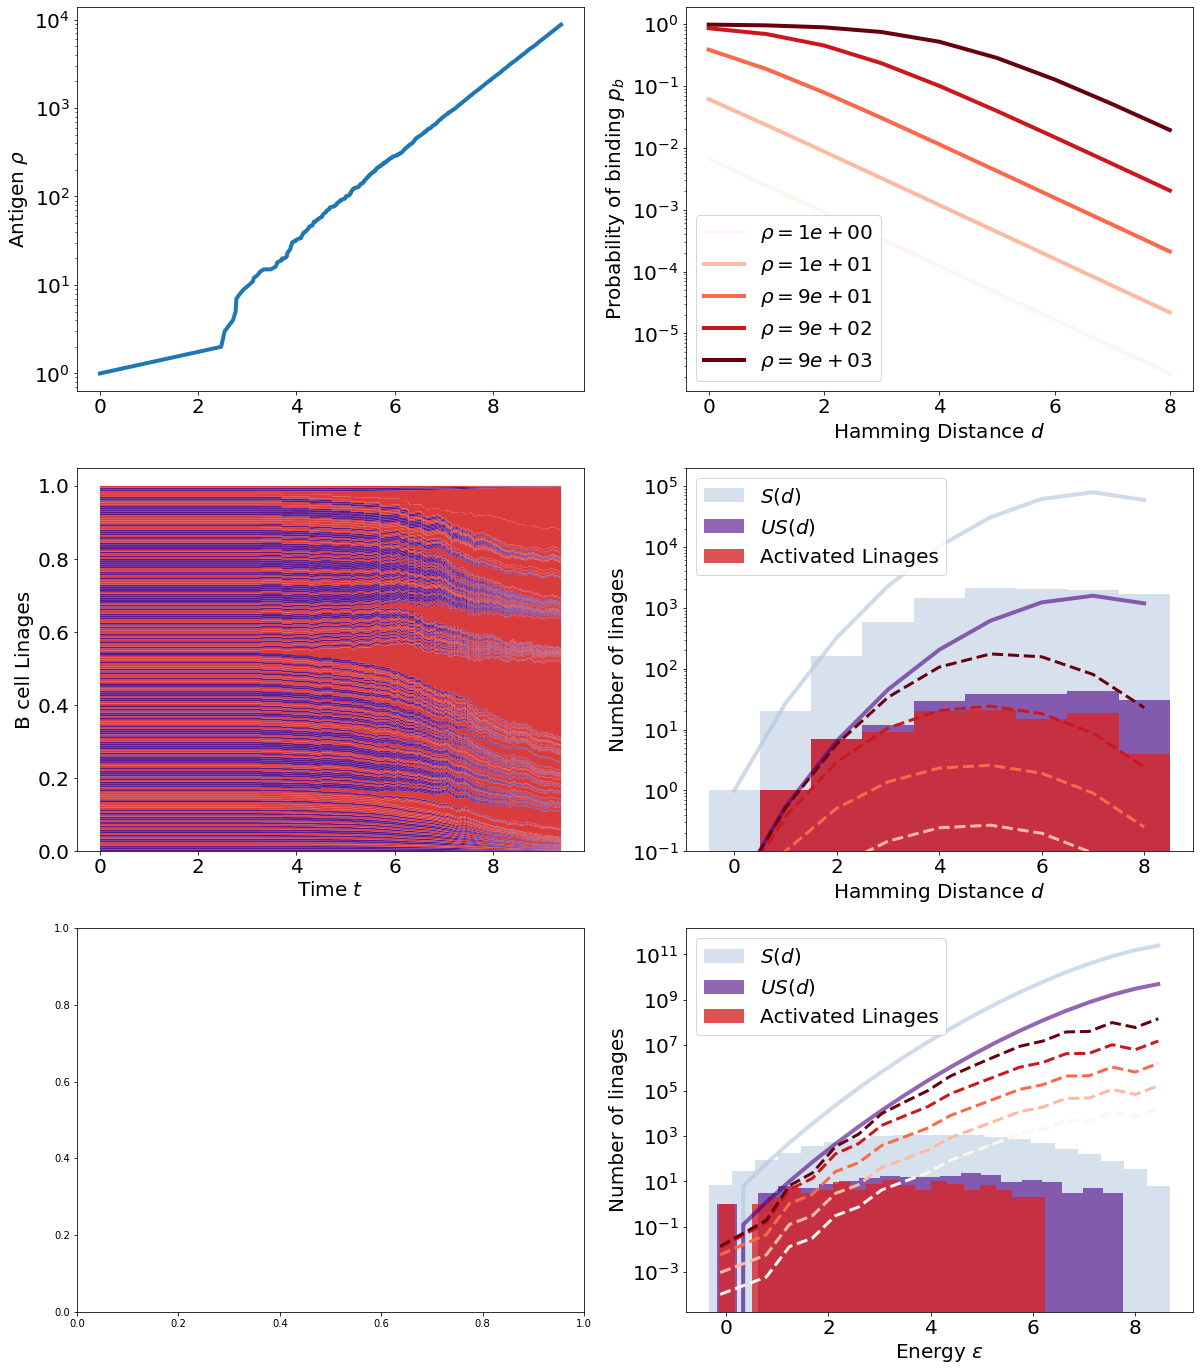

In [15]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

Model.plot_antigen_time(ax = ax[0,0])
Model.plot_prob_binding(ax = ax[0,1])
Model.stackplot_linages_time(ax = ax[1,0])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[1,1])
Model.hist_sequences_energy(Sequences = Sequences, ax = ax[2,1])

counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))


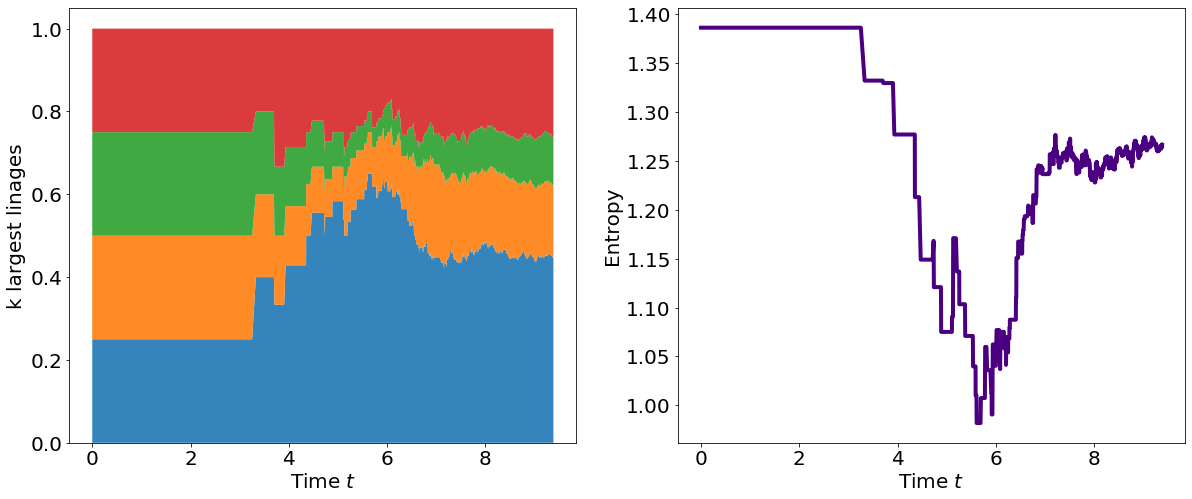

In [16]:
fig, ax = plt.subplots(1,2,figsize=(20,8))

#Calculate array of the frequencies of the largest k linages
Seq_states = [i.active for i in Model.Sequences]
Seq_sizes = Model.linages_time_series[:,-1]
k = 4
biggest_k_linages_sizes = np.sort(Seq_sizes)[-k:]
Pos = np.array([i for i, j in enumerate(Seq_sizes) if np.isin(j,biggest_k_linages_sizes)])
biggest_k_linages = Model.linages_time_series[Pos,0]
for i in range(1,int(len(Model.linages_time_series[0,:]))):
    biggest_k_linages = np.vstack((biggest_k_linages, Model.linages_time_series[Pos,i]))
biggest_k_linages_freq = np.transpose(biggest_k_linages)/np.sum(np.transpose(biggest_k_linages), axis = 0)

ax[0].stackplot(Model.time_series, biggest_k_linages_freq, alpha = 0.9);
#ax[0].set_yscale('log')
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'k largest linages', fontsize = 20)
ax[0].tick_params(labelsize = 20)

#___________________________________________________________________

#Calculate entropy
entropy = [np.sum(-1*biggest_k_linages_freq[:,t]*np.log(biggest_k_linages_freq[:,t])) for t in range(int(len(Model.time_series)))]
ax[1].plot(Model.time_series, entropy, linewidth = '4', color = 'indigo')
#ax[1].set_yscale('log')
ax[1].set_xlabel(r'Time $t$', fontsize = 20)
ax[1].set_ylabel(r'Entropy', fontsize = 20)
ax[1].tick_params(labelsize = 20)

counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Entropy_%d.png'%(counter))

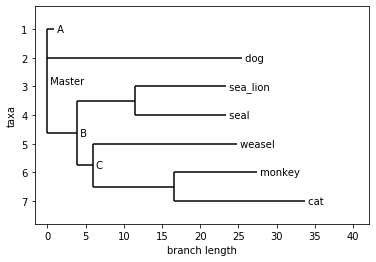

In [17]:
tree = Phylo.read(StringIO("Master(A():0.84600,B((sea_lion:11.99700, seal:12.00300):7.52973,C((monkey:10.85930,cat:17.14069):10.59201, weasel:18.87953):2.09460):3.87382,dog:25.46154):0"), "newick")
tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

In [18]:
distances = np.array([])
for i in range(n_seq):
    distances = np.append(distances,Sequences[i].hamming_distance)

In [19]:
data_distances = np.histogram(distances, bins=range(int(max(distances))))

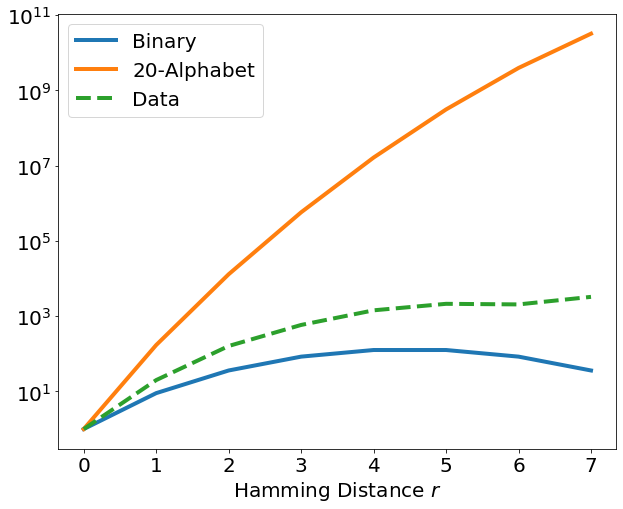

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(data_distances[1][0:-1], scipy.special.comb(9, data_distances[1][0:-1]), linewidth = 4 , label = 'Binary')
ax.plot(data_distances[1][0:-1], scipy.special.comb(9, data_distances[1][0:-1])*((20-1)**data_distances[1][0:-1]), linewidth = 4 , label = '20-Alphabet')
#ax.plot(data_distances[1][0:-1], np.exp(4*data_distances[1][0:-1]), linewidth = 4, label = r'$e^{\lambda r}$')
ax.plot(data_distances[1][0:-1], data_distances[0], linewidth = 4, label = 'Data', linestyle = 'dashed')

ax.set_yscale('log')
#ax.set_ylim(1,1e10)
ax.set_xlabel(r'Hamming Distance $r$', fontsize = 20)
ax.set_ylabel(r'', fontsize = 20)
ax.tick_params(labelsize = 20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.concatenate(([],handles)),np.concatenate(([],labels)), loc = 0, fontsize = 20)
#fig.savefig('../Figures/S_r_0.png')


In [21]:
energies = np.array([])
for i in range(n_seq):
    energies = np.append(energies,Sequences[i].energy)

In [22]:
data_energies = np.histogram(energies, bins=10)

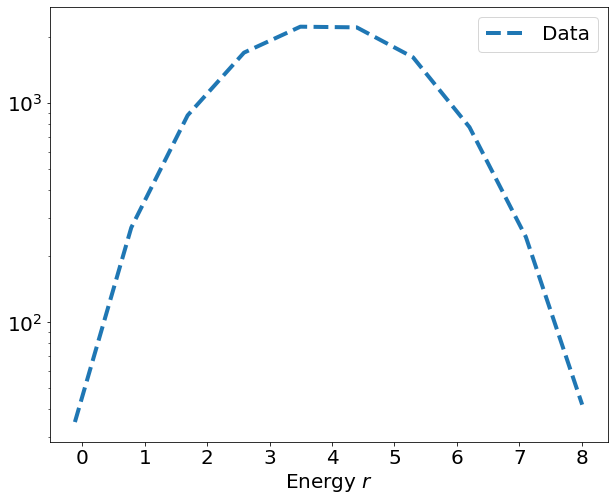

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
#ax.plot(data_distances[1][0:-1], scipy.special.comb(9, data_distances[1][0:-1]), linewidth = 4 , label = 'Binary')
#ax.plot(data_distances[1][0:-1], scipy.special.comb(9, data_distances[1][0:-1])*((20-1)**data_distances[1][0:-1]), linewidth = 4 , label = '20-Alphabet')
#ax.plot(data_distances[1][0:-1], np.exp(4*data_distances[1][0:-1]), linewidth = 4, label = r'$e^{\lambda r}$')
ax.plot(data_energies[1][0:-1], data_energies[0], linewidth = 4, label = 'Data', linestyle = 'dashed')

ax.set_yscale('log')
#ax.set_ylim(1,1e10)
ax.set_xlabel(r'Energy $r$', fontsize = 20)
ax.set_ylabel(r'', fontsize = 20)
ax.tick_params(labelsize = 20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.concatenate(([],handles)),np.concatenate(([],labels)), loc = 0, fontsize = 20)
#fig.savefig('../Figures/S_r_0.png')

